In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# path to/from which we will load/download on our machine
train_path = './data/MNIST_train'

# download/load data to/from path, select training set, download if not already
trainset = torchvision.datasets.MNIST(root=train_path, train=True, download=True)

# The dataset class has two important methods: __len__ and __getitem__.
length = len(trainset) # length 60000
item0 = trainset[0] # data, value

# The items of an instance of the dataset class are tuples of data 
# and values (features and labels).

# The data in the MNIST data set are images of form PIL.Image.Image.
img0 = item0[0] # PIL.Image.Image
val0 = item0[1] # 5

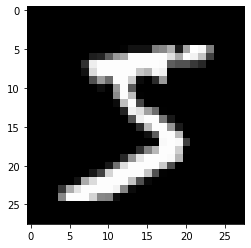

In [3]:
# We can view these images by using #plt.imshow().
plt.imshow(img0, cmap='gray')
plt.show()

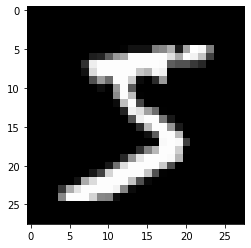

In [4]:
# To use pytorch, we need to convert our data into a an acceptable type for the framework... 
# the so-called "tensor" (it's really just a multidimensional array)

# We can use the ToTensor transform in torchvision.transforms to convert our data to tensors.
totensor = transforms.ToTensor()
img0_t = totensor(img0)

# We can see the shape of our tensors using the size method.
img_size = img0_t.size() # 1x28x28

# the size of images converted to tensors is CxHxW where C is the number of channels (1: grayscale, 3:RGB)
# and H,W are the height and width of the image.
# The images in the MNIST dataset are gray-scale 28x28 pixels, so there is only 1 channel. 

# If we want to view the picture after converting to a tensor, we need to be careful. 
# Pytorch converst the image to a CxHxW sized array, but matplotlib expects: 
#     a) - a HxW sized array if grayscale 
#     b) - a HxWxC sized array if the number of channels is more than 1  

# To view our image, just slice off the first index
sliced = img0_t[0,:,:]
plt.imshow(sliced, cmap='gray')

# To view an RGB image after transforming to tensor, use the permute method of the Tensor class:  
# permuted = img0_t.permute(1, 2, 0) # moves first index to last and shifts other two up
# plt.imshow(permuted)

In [5]:
# We can transform each image to a tensor at load time by using the transform option.
trainset_t = torchvision.datasets.MNIST(root=train_path, train=True, download=True, transform=transforms.ToTensor())

In [6]:
# Since neural nets work train better when the training data features fall between 0 and 1, 
# we need to normalize our tensors so that all the values in each tensor fall in that range. 
# A common way to do this is to find the mean and standard deviation for the data and then 
# subtract off the mean and divide by the standard deviation.

# We can do this by stacking all our tensor images along an extra dimension:
imgs_t = torch.stack([img_t for img_t, _ in trainset_t], dim=3)

In [7]:
# The shape should be 1x28x28xlen(trainset)
imgs_size = imgs_t.size() # 1x28x28x60000

# We can easily compute the mean and standard deviation by channel using view, mean and std methods 
# of the Tensor class. 

# keep the channels (our case: 1) and merge the other dimensions into one
imgs_flat = imgs_t.view(1, -1) # C x rest

# find the mean and standard deviation of each channel
mu = imgs_flat.mean(dim=1) # 0.1306
sigma = imgs_flat.std(dim=1) # 0.3081

# to get value in a value of a one entry tensor, use item methoth
mu = mu.item()
sigma = sigma.item()

# if channels > 1, use list comprehension andt item method and pass 
# list of means and standard deviations to transforms.Normalize:
# ex) mu = [a.item() for a in imgs_flat.mean(dim=1)]

In [8]:
# If we know the means and standard deviations for the data beforehand, we can normalize our data at 
# load time by using transforms.Compose() and transforms.Normalize(). 
trainset_t = torchvision.datasets.MNIST(root=train_path, train=True, download=True, 
                                        transform=transforms.Compose([transforms.ToTensor(), 
                                                                     transforms.Normalize(mu, sigma)]))

In [9]:
# In pytorch we need to load the data using the Data.Loader to train a network. The Data.Loader 
# handles partitioning the data into batches for various training techniques. The Data.Loader 
# can also shuffle the data which is useful for various training techniques.  

# prepare data, batch and shuffle
trainset_loader = torch.utils.data.DataLoader(trainset_t, batch_size=60, shuffle=True)

# An instance of Data.Loader has a __len__ method
loader_length = len(trainset_loader) # 1000 which is about 60000/60 = len(trainset)/batch_size

# However, an instance of Data.Loader does not have a __getitem__ method. The most common way to get over this
# is to just to enumerate the loader and loop over it. 
for i, data in enumerate(trainset_loader):
    break
    
# In training, everything in batches is 
# handled automatically

In [10]:
# Lets recap and load in all our data for use later. 

# find mean/std of data
train_path = './data/MNIST_train'
test_path = './data/MNIST_test'

train_set = torchvision.datasets.MNIST(root=train_path, train=True, download=True, transform=transforms.ToTensor())

train_imgs = torch.stack([img for img, _ in train_set], dim=3)
train_flat = train_imgs.view(1, -1)
mu = train_flat.mean(dim=1).item()
sigma = train_flat.std(dim=1).item()

# make transform to convert to tensor and normalize 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mu, sigma)])

# prepare data
train_set = torchvision.datasets.MNIST(root=train_path, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=60, shuffle=True)

test_set = torchvision.datasets.MNIST(root=test_path, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=60, shuffle=False)

In [11]:
# Now we are ready to make neural network, train them, and profit. We will start with two 
# simple, totally connected network. 

# First will create the standard multiclass logistic regression model as a benchmark. We can think 
# of each image as a 28 * 28 = 784 length point which we will operate on and classify as one of 10 classes.
# We will have one linear layer that has input dimension 784 and output dimension 10. We will then use the 
# softmax function to convert the output to probabilities then train the network. 

import torch.nn as nn
import torch.optim as optim

# create logistic regression neural net
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc = nn.Linear(784, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # totally flatten the image to length H*W = 784
        x = x.view(-1, 784)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x
    
model = LR()

In [12]:
# define a loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.001, momentum=.9)

In [19]:
# how many times to loop over data
epochs = 2

#train network
for epoch in range(epochs):
    
    for i, data in enumerate(train_loader):
        #get inputs, labels
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('finished training')
        
# save trained model
save_path = './MNIST_LR.pth'
torch.save(model.state_dict(), save_path) 

finished training


In [20]:
# evaluate on testing data
total = 0
correct = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'accuracy is {correct / total * 100} percent')

accuracy is 98.39 percent


In [21]:
# The accuracy was not bad, but we can do better by creating a network with another layer
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LRpp(nn.Module):
    def __init__(self):
        super(LRpp, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        
        return x

def train(model, criterion, optimizer, train_loader, epochs=2):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader):
            #get inputs, labels
            inputs, labels = data
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward, backward, optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print('finished training')
        
    # save trained model
    save_path = './MNIST_LRpp.pth'
    torch.save(model.state_dict(), save_path) 
    
    return None
    
def evaluate(model, test_loader):
    # evaluate on testing data
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'accuracy is {correct / total * 100} percent')
    
    return None

In [22]:
model = LRpp()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.9)

train(model, criterion, optimizer, train_loader, epochs=2)

evaluate(model, test_loader)

finished training
accuracy is 93.62 percent


In [23]:
# So our accuracy has increased a bit, but we can go even further... using a convolutional neural network.  

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        # batch x 1 x 28 x 28
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) # batch x 16 x 14 x 14
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) #: batch x 32 x 7 x 7 
        self.fc1 = nn.Linear(32*7*7, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 32*7*7) # flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        
        return x
        
def train(model, criterion, optimizer, train_loader, epochs=2):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader):
            #get inputs, labels
            inputs, labels = data
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward, backward, optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print('finished training')
        
    # save trained model
    save_path = './MNIST_CNN.pth'
    torch.save(model.state_dict(), save_path) 
    
    return None
    
def evaluate(model, test_loader):
    # evaluate on testing data
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'accuracy is {correct / total * 100} percent')
    
    return None

In [24]:
model = CNN()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=.9)

train(model, criterion, optimizer, train_loader, epochs=2)

evaluate(model, test_loader)

finished training
accuracy is 98.05 percent
